## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

Padded BG data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [3]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [46]:
data_dir = Path('data_02')
data_orig=Path('data')

In [5]:
RETRAIN = True
RESIZE_IMAGES = True

In [6]:
MODEL_NAME='cv_reflect_101_valid'

In [7]:
NB_NUM='03_21'

In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: f2b8b8c6, DATE: 20191118


In [9]:
DATE = '20191118'
UID = '7607ef2d'

In [10]:
SUB_NUM='20'

In [11]:
#wrap or reflect
border='reflect'
#padded or padded_bg
pad_type='padded'
img_size=256

In [12]:
train_images=data_dir/f'train/rotated/clipped/{pad_type}/{border}/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{pad_type}/{border}/{img_size}'

In [13]:
test_names = get_image_files(test_images)

In [14]:
assert len(test_names)==7325

In [15]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [16]:
len(df_all)

22553

In [17]:
df_valid=df_all.loc[df_all['verified'] == True]

In [18]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [19]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [20]:
assert len(df_test)==7325

In [21]:
df_valid.loc[df_valid['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [22]:
len(df_valid)

14870

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [23]:
xtra_tfms=[dihedral(p=0.7), rand_crop(p=0.4)]
tfms = get_transforms(flip_vert=True, max_lighting=0.2, max_zoom=1.1, max_warp=0., xtra_tfms=xtra_tfms)
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [24]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [25]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [26]:
#to check what params object has
#dir(data)

In [27]:
data.label_list

LabelLists;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256

In [28]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

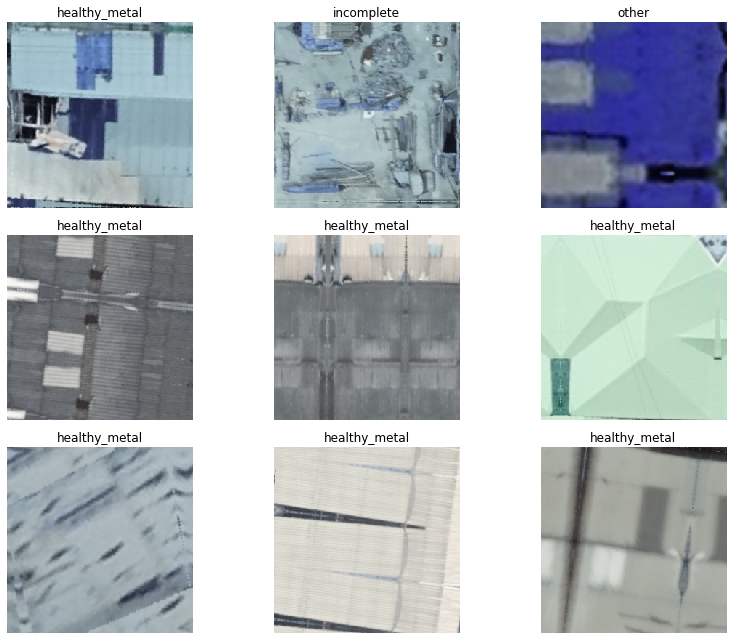

In [29]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [30]:
arch = models.resnet101
arch_name = 'rn101'

In [31]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

In [32]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


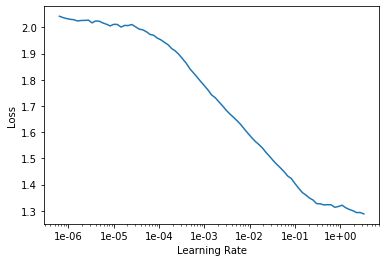

In [34]:
learn.recorder.plot()

Then we can fit the head of our network.

In [35]:
lr = 2e-3

In [36]:
#learn.fit_one_cycle(5, slice(lr))

In [37]:
print(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

stage-1-rn101-03_21-cv_reflect_101_valid-20191118-7607ef2d


In [38]:
#learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [39]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size

In [40]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.566609,0.575685,0.191661,00:58
1,0.556845,0.552164,0.191997,00:59
2,0.522358,0.531906,0.190989,01:01
3,0.492438,0.523190,0.189307,01:05
4,0.466211,0.525121,0.185609,01:05


<pre>
with basic transforms
 epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.562351 	0.574500 	0.198050 	01:15
1 	0.527951 	0.546892 	0.191325 	01:15
2 	0.521544 	0.534884 	0.193006 	01:10
3 	0.467845 	0.518976 	0.182582 	01:13
4 	0.453595 	0.517248 	0.185609 	01:13
    </pre>

In [41]:
learn.save(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [42]:
learn.load(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 184),
 ('healthy_metal', 'irregular_metal', 148),
 ('incomplete', 'irregular_metal', 59),
 ('incomplete', 'concrete_cement', 28),
 ('concrete_cement', 'healthy_metal', 24),
 ('healthy_metal', 'concrete_cement', 21),
 ('concrete_cement', 'irregular_metal', 17),
 ('other', 'healthy_metal', 17),
 ('irregular_metal', 'concrete_cement', 16),
 ('incomplete', 'healthy_metal', 12),
 ('concrete_cement', 'incomplete', 8),
 ('irregular_metal', 'incomplete', 6),
 ('other', 'irregular_metal', 4),
 ('healthy_metal', 'incomplete', 3),
 ('healthy_metal', 'other', 3),
 ('irregular_metal', 'other', 2)]

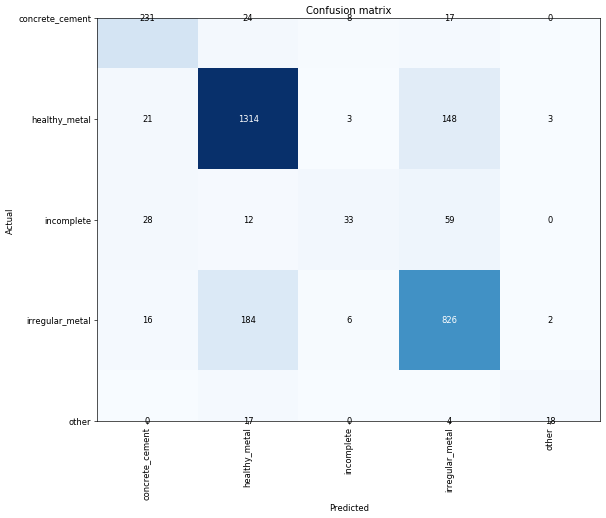

In [44]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [45]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


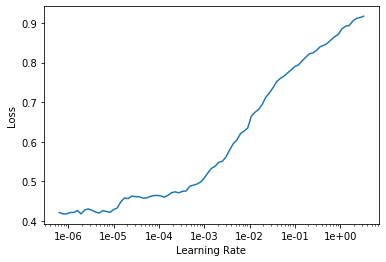

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(5, slice(2e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.483505,0.518372,0.186617,01:23
1,0.488228,0.506981,0.184936,01:23
2,0.433271,0.507793,0.188299,01:22
3,0.382772,0.501747,0.178547,01:21
4,0.360602,0.497253,0.178884,01:24


<pre>
with basic transforms
epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.451103 	0.523114 	0.190316 	01:31
1 	0.452008 	0.511090 	0.183255 	01:31
2 	0.421201 	0.510209 	0.185945 	01:31
3 	0.374940 	0.506673 	0.181237 	01:24
4 	0.351982 	0.506825 	0.178211 	01:22
    </pre>

In [48]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [32]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size

In [50]:
#learn.fit_one_cycle(5, slice(5e-7, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.366578,0.513071,0.182246,01:22
1,0.357664,0.526695,0.186954,01:21
2,0.329574,0.521772,0.184600,01:22
3,0.308986,0.528041,0.182246,01:21
4,0.296234,0.526147,0.182582,01:21


<pre>
with basic transforms
 epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.341163 	0.521209 	0.190652 	01:22
1 	0.341612 	0.525128 	0.185945 	01:21
2 	0.317868 	0.523340 	0.188299 	01:22
3 	0.290191 	0.534077 	0.188299 	01:20
4 	0.271088 	0.526659 	0.186281 	01:22
    </pre>

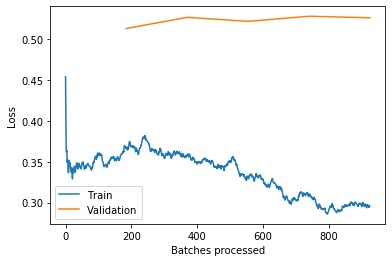

In [51]:
#learn.recorder.plot_losses()

In [52]:
#learn.save(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [53]:
#learn.load(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size

In [54]:
#learn=learn.to_fp32()

In [55]:
#learn.export()

### Larger size images

In [33]:
train_images=data_dir/f'train/rotated/clipped/{pad_type}/{border}/512'
test_images=data_dir/f'test/rotated/clipped/{pad_type}/{border}/512'

In [34]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [35]:
data = (src.transform(tfms, size=512)
        .databunch(bs=16).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [36]:
learn=learn.to_fp16()

In [37]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


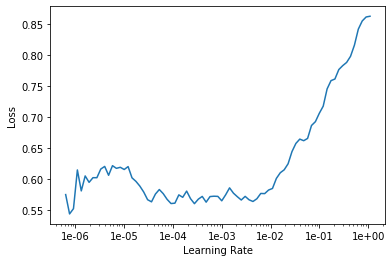

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
lr=2e-5

In [40]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.603396,0.569861,0.200740,04:29
1,0.546546,0.536065,0.195360,04:44
2,0.611368,0.529171,0.189644,04:37
3,0.543444,0.542726,0.194015,04:17
4,0.563926,0.534523,0.194015,03:57


In [41]:
learn.save(f'stage-1-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [42]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


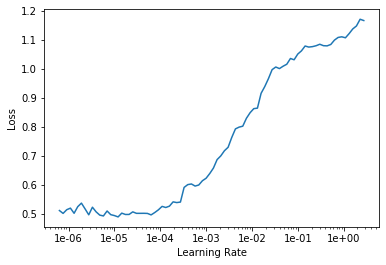

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(5, slice(5e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.529043,0.521002,0.188299,06:13
1,0.570311,0.508566,0.189980,06:17
2,0.483160,0.501457,0.179892,05:49
3,0.494660,0.504008,0.181237,05:29
4,0.466922,0.499594,0.180565,05:20


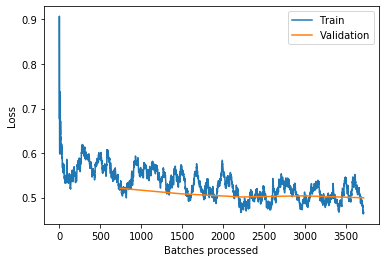

In [45]:
learn.recorder.plot_losses()

In [48]:
learn.save(f'stage-2-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [88]:
learn.load(f'stage-2-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (7325 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: data_02/train/rotated/clipped/padded/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [89]:
learn=learn.to_fp32()

In [90]:
learn.export()

### inference

In [92]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{pad_type}/{border}/512'
test_dataset=ImageList.from_folder(test_images)

In [93]:
len(test_dataset)

7325

In [94]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{pad_type}/{border}/{img_size}', test=test_dataset)

In [95]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [96]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [97]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [98]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [99]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [100]:
labels = np.argmax(preds, 1)

In [101]:
len(preds)

7325

In [102]:
preds[0].tolist()

[0.12749601900577545,
 0.8609005212783813,
 0.004774764180183411,
 0.0012307175202295184,
 0.0055980077013373375]

In [103]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [104]:
len(labels)

7325

In [105]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [106]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [107]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [108]:
test_predictions[0]

'healthy_metal'

In [109]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [110]:
 learn.data.test_ds.x.items

array([PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4d9168.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4ae922.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a48ca98.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a49c614.tif'), ...,
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a486800.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4c49fc.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a501f50.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4d27b4.tif')], dtype=object)

In [111]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [112]:
preds_list[0]

[0.12749601900577545,
 0.8609005212783813,
 0.004774764180183411,
 0.0012307175202295184,
 0.0055980077013373375]

In [113]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [114]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [115]:
df.head()

,id,pred
0,7a4d9168,"[0.12749601900577545, 0.8609005212783813, 0.00..."
1,7a4ae922,"[0.009412658400833607, 0.9386434555053711, 0.0..."
2,7a48ca98,"[0.010993237607181072, 0.37393438816070557, 0...."
3,7a49c614,"[0.0056078266352415085, 0.8063565492630005, 0...."
4,7a4dd4f2,"[0.003935875371098518, 0.9768233299255371, 0.0..."


In [116]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [117]:
pred_df.insert(loc=0, column='id', value=ids)

In [118]:
pred_df.columns = cols

In [119]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.127496,0.860901,0.004775,0.001231,0.005598
1,7a4ae922,0.009413,0.938643,0.006521,0.041012,0.004411
2,7a48ca98,0.010993,0.373934,0.025437,0.580117,0.009518
3,7a49c614,0.005608,0.806357,0.003430,0.179934,0.004671
4,7a4dd4f2,0.003936,0.976823,0.007340,0.003360,0.008541


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [120]:
pred_ids=pred_df['id'].values.tolist()

In [121]:
df_baseline = pd.read_csv(data_orig/f'submissions/mean_baseline.csv')

In [122]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [123]:
baseline_ids=df_baseline['id'].values.tolist()

In [124]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [125]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [126]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.127496,0.860901,0.004775,0.001231,0.005598,7a4d9168
1,7a4ae922,0.009413,0.938643,0.006521,0.041012,0.004411,7a4ae922
2,7a48ca98,0.010993,0.373934,0.025437,0.580117,0.009518,7a48ca98
3,7a49c614,0.005608,0.806357,0.003430,0.179934,0.004671,7a49c614
4,7a4dd4f2,0.003936,0.976823,0.007340,0.003360,0.008541,7a4dd4f2


In [127]:
pred_df=pred_df.sort_values('id_cat')

In [128]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
716,7a4d630a,0.019448,0.958343,0.012323,0.000619,0.009267,7a4d630a
764,7a4bbbd6,0.005254,0.920592,0.007642,0.059653,0.006859,7a4bbbd6
1841,7a4ac744,0.010889,0.839507,0.008034,0.133340,0.008230,7a4ac744
3363,7a4881fa,0.012288,0.077765,0.022431,0.880410,0.007105,7a4881fa
133,7a4aa4a8,0.022831,0.905528,0.015815,0.046184,0.009642,7a4aa4a8


In [129]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [130]:
pred_df.to_csv(data_orig/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

### Submission 2: 0.5733


In [132]:
arch_name = 'rn101'
pred_df=pd.read_csv(data_orig/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

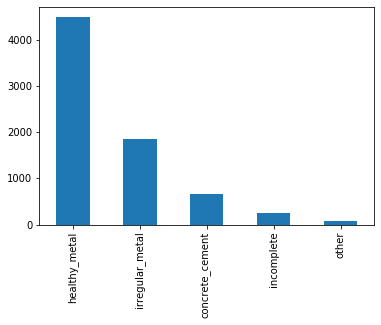

In [133]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")